<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/SamstagVersionFallstudie1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie


##PIP, OR-Tools und Pandas

In [2]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.19.1 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.0 which is incompatible.
google-colab 1.0.0 requi

In [3]:
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

In [4]:
#clone der Daten aus der GithubRepo und Einlesen der DF
! git clone https://github.com/AlexKressner/Industrielles_Management
path = "Industrielles_Management/Daten/Fallstudie/"
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

Cloning into 'Industrielles_Management'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 110 (delta 7), reused 0 (delta 0), pack-reused 90
Receiving objects: 100% (110/110), 548.57 KiB | 8.19 MiB/s, done.
Resolving deltas: 100% (39/39), done.


##Daten:


###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [5]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten q als (i, j) Tupel
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \: \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Binärvariable, die angibt, ob Dark Store Standort $ s $ den Quadranten $ q $ beliefert $1$ oder nicht $0$.

$ z_{qs} \in \{0,\infty\} \: \: \: \forall q \in Q, \forall s \in S$: Int-Variable, die die absolute Liefermenge von Darkstore $ s $ an Quadranten $ q (i,j) $ repräsentiert.


In [6]:
# Wird der store s errichtet? (0,1)
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [7]:
# Liefert der Store s an Quadranten Q? (0,1)
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.BoolVar(f'y[{q},{s}]')

In [8]:
# Wie viel Nachfrage deckt jeder Store s fuer einen Quadraten Q ab? (0-Infinity)
z = {}
for s in S:
    for q in Q:
        z[q, s] = solver.IntVar(0, solver.infinity(), f'z[{q},{s}]')

###Dictonaries:


In [9]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q (i,j) $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ G $: Geschwindigkeit des Fahrradkuriers in KM/h.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores.

$ T $: Maximale Lieferzeit.

$ TV $: Verbleibende Lieferzeit abzüglich aller Zeitfresser.

$ A $: Maximale Anzahl von Quadranten, die ein Fahrradkurier bedienen kann.

In [23]:
D = {q: nachfrage_df.iat[q[0],q[1]] for q in Q} # Quadratennachfrage D[q] die Nachfrage an Quadrant Koordinaten q_zeilen, q_spalten
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung L[s] des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung C[s] eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget B für die Einrichtung von Dark Stores
G = 25  # Geschwindigkeit G (km/h)
T = 20  # Maximale Lieferzeit T (min)
TF1= 3  # Zeit fuer Warenbereitstellung TF1
TF2= 1  # Zeit fuer Warenuebergabe TF2
TV= (T-TF1-TF2) # Verbleibende Lieferzeit TV
A = round((TV/2)/0.25*G/60, None) # max Reichweite in Quadranten für eine Richtung

###Zielfunktion:


Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{qs} z_{qs} $

In [24]:
# Maximiere die variable Liefermenge z[q,s]
solver.Maximize(solver.Sum([z[q, s] for q in Q for s in S]))


###Restriktionen:
1. **Store Lieferrestriktion**: Für jeden Store $s$, wenn $x[s] = 0$, dann kann der Store nicht liefern.
   $x[s] \geq y[q, s], \quad \forall s \in S, \forall q \in Q$

2. **Nachfrageabdeckung 100%**: Die Summe der Lieferungen aller Stores zu einem Quadranten $q$ muss genau der Nachfrage dieses Quadranten entsprechen.
   $\sum_{s \in S} z[q, s] = D[q], \quad \forall q \in Q$

3. **Liefermengerestriktion**: Die Summe der bedienten Nachfrage darf die Nachfrage des Quadranten $q$ nicht übersteigen.
   $\sum_{s \in S} z[q, s] \leq D[q], \quad \forall q \in Q$

4. **Zulieferungsrestriktion**: Die Summe der Stores, die einen Quadranten $q$ beliefern, darf nicht größer als 2 sein.
   $\sum_{s \in S} y[q, s] \leq 2, \quad \forall q \in Q$

5. **Lagerumschlagleistungsrestriktion**: Die Summe der bedienten Nachfrage darf nicht größer sein als die Kapazität des Stores $s$.
   $\sum_{q \in Q} z[q, s] \leq x[s] \cdot L[s], \quad \forall s \in S$

6. **Reichweitenrestriktion für Fahrradkuriere**: Für jeden Store $s$ und jeden Quadranten $q$, wenn die Manhattan-Distanz größer als $A$ ist, dann sind $y[q, s]$ und $z[q, s]$ gleich 0.
   $y[q, s] = z[q, s] = 0, \quad \text{wenn } |i_s - i_q| + |j_s - j_q| > A, \quad \forall s \in S, \forall q \in Q$

7. **Budgetrestriktion**: Die Summe der Kosten aller erbauten Stores darf nicht größer sein als das Budget $B$.
   $\sum_{s \in S} x[s] \cdot C[s] \leq B$

In [25]:
#Store Lieferrestriktion: Ein Store s kann nur liefern, falls er errichtet wurde x[s]
for s in S:
    for q in Q:
        solver.Add(y[q, s] <= x[s])

In [26]:
#Nachfrageabdeckung 100%: Für jedes q prüfen, ob die Summe der Lieferungen aller S zu diesem q --> z[q,s] GENAU der Nachfrage dieses Quadraten enspricht.
for q in Q:
    solver.Add(solver.Sum(z[q, s] for s in S) - solver.Sum(D[q]*y[q, s] for s in S)==0)

In [27]:
#Liefermengerestriktion: Für jedes q prüfen, ob die Summe der bedienten Nachfrage sum(z[q,s]) über alle S die Nachfrage des Quadranten D[q] nicht übersteigt.
for q in Q:
    solver.Add(solver.Sum([z[q, s] for s in S]) <= D[q])

In [28]:
#Zulieferungsrestriktion: Für jedes q prüfen, ob die Summe der Stores die diesen Quadraten beliefern Sum(y[q, s]) kleiner gleich 2 ist.
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 2)

In [29]:
#Lagerumschlagleistungsrestriktion: Für jedes s prüfen, ob die Summe der bedienten Nachfrage kleiner ist als die Kapazität des Stores L[s] mit x[s] werden nur gebaute Stores berücksichtigt
for s in S:
    solver.Add(solver.Sum([z[q, s] for q in Q]) <= x[s] * L[s])

In [30]:
#Reichweitenrestriktion für Fahrradkuriere: Prüfe für jeden Store s und jeden Quadranten q, ob die Manhattan Distanz für Belieferungsentscheidung y und -Menge z kleiner gleich A ist
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > 5:
            solver.Add(z[q, s] == 0)
            solver.Add(y[q, s] == 0)

In [31]:
#Budgetrestriktion: Prüfe, ob die Summe der Kosten C[s] aller erbauten Stores X[s] kleiner gleich dem Budget B ist.
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x780331030840> >

##Lösung:

In [32]:
# Lösen des Modells
status = solver.Solve()

In [ ]:
if status == pywraplp.Solver.OPTIMAL:
    gesamtnachfrage = sum(D.values())
    ausgelieferte_waren = sum(z[q, s].solution_value() for q in Q for s in S if z[q, s].solution_value() > 0)
    print(f'Prozentuale Erfüllung der Gesamtnachfrage: {round((ausgelieferte_waren/gesamtnachfrage*100), ndigits=2)}%')
    print('Lösung gefunden:')
    print('Zielfunktionswert (Kosten) =', round(solver.Objective().Value()))
    for s in S:
        if x[s].solution_value() == 1:
            print(f'Standort {s} wird eingerichtet.')
            vollstaendig = [q for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() == D[q]]
            if vollstaendig:
                print(f'Vollständige Lieferungen von Standort {s} mit {", ".join(str(q) for q in vollstaendig)} vollständig beliefert.')
            teilweise = [(q, round(z[q, s].solution_value()/D[q]*100)) for q in Q if z[q, s].solution_value() > 0 and z[q, s].solution_value() != D[q]]
            if teilweise:
                print(f'Teilweise Lieferungen von Standort {s} mit {", ".join(f"{q[0]} ({q[1]}%)" for q in teilweise)} beliefert.')
    # # Ausgabe der angefragten Menge und der tatsächlich gelieferten Waren für jeden Quadranten
    # for q in Q:
    #     angefragte_menge = D[q]
    #     gelieferte_waren = sum(z[q, s].solution_value() for s in S if z[q, s].solution_value() > 0)
    #     print(f'Quadrant {q}:Gelieferte ({gelieferte_waren}/{angefragte_menge}) -> {gelieferte_waren/angefragte_menge*100}%')
else:
    print('Keine optimale Lösung gefunden.')

### Darstellung als Matrix, DF oder MatPlot

In [34]:
import numpy as np
import pandas as pd

# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Initialize the matrix with None to indicate empty cells
ergebnis_matrix = np.full((14, 14), None, dtype=object)

# Fill the matrix with the results from your model
for s in S:
    if x[s].solution_value() > 0:
        for q in Q:
            if z[q, s].solution_value() >= 1:
                if ergebnis_matrix[q[0], q[1]] is not None:
                    ergebnis_matrix[q[0], q[1]] += str(s)
                else:
                    ergebnis_matrix[q[0], q[1]] = str(s)

# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:  # Wenn ein Darkstore an diesem Standort errichtet wurde
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

#ergebnis_matrix=np.where(ergebnis_matrix =='',None, ergebnis_matrix)
# Konvertieren Sie die Matrix in einen DataFrame für eine schönere Darstellung
ergebnis_df = pd.DataFrame(ergebnis_matrix).transpose()
ergebnis_df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,None,None,None,9,9,9,None,None,None,None,2,2,None,None
1,None,None,9,9,7,9,9,None,2,2,None,2,2,None
2,None,9,9,7,7,7,9,9,2,2,None,2,4,None
3,9,9,7,7,7,7,7,9,9,2,2,4,4,None
4,9,7,7,7,S9,9,7,9,9,9,S2,4,4,None
5,7,7,9,7,9,7,9,7,7,4,4,4,24,None
6,7,9,7,7,S7,7,7,7,7,7,4,3,4,S4
7,7,7,7,7,7,7,9,7,7,14,3,4,3,None
8,5,7,7,7,S5,7,7,7,5,1,1,3,3,None
9,5,5,7,7,7,7,7,1,5,1,1,4,3,None


####Visualisierung

<ipython-input-35-f301535296cf>:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  num_matrix = num_matrix.fillna(-1)


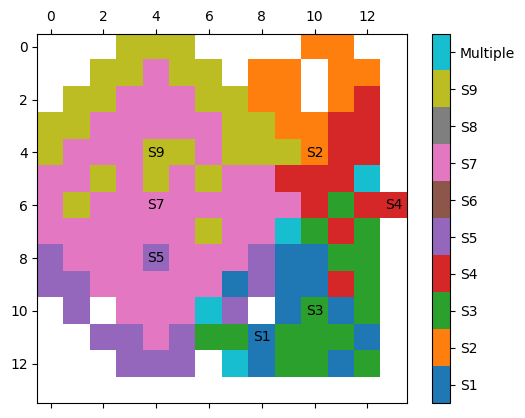

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_df.copy()
for i in range(14):
    for j in range(14):
        if num_matrix.iloc[i, j] is not None and isinstance(num_matrix.iloc[i, j], str):
            if "S" in num_matrix.iloc[i, j]:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j].replace("S", ""))
            else:
                num_matrix.iloc[i, j] = int(num_matrix.iloc[i, j])
# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix = num_matrix.fillna(-1)
# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan
# Ersetzen Sie alle int Werte über 10 durch -2
num_matrix[num_matrix > 10] = 11
# Create a new color map with an extra color for the '10' value
cmap = plt.get_cmap('tab10', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 2))  # 'tab20' provides 20 distinct colors
# Set the color for 'None' and '10'
cmap.set_under('white')  # For 'None'
cmap.set_over('gray')  # For '10'
# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()
cax = ax.matshow(num_matrix, cmap=cmap, vmin=0)  # Setzen Sie vmin auf 0, um die untere Grenze der Farbkarte festzulegen
# Create the colorbar with custom boundaries
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)), boundaries=np.arange(+0.5, np.nanmax(num_matrix)+0.5))  # +2.5 to include '10' and 'None'
# Set the labels
labels = ['S'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix)-1))] + ['Multiple']  # Add labels for 'None' and '10'
cbar.ax.set_yticklabels(labels)
# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        j, i = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'S{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()